# Spectral analysis of a sequence of Metis images   

This notebook is an example of spectral analysis to study fluctuations and oscillations in a sequence of the total brightness visible light Metis images acquired with a cadence of 300 s.

In the following cell we import the python modules needed for the subsequent calculations

In [1]:
%matplotlib inline
#%matplotlib notebook

import scipy as sp
import numpy as np
from scipy import signal as sig
from matplotlib import pylab as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
import glob
from astropy.io import fits
from scipy import ndimage
from scipy.ndimage import gaussian_filter as smooth

Here we set the path to folder containing the data and make a list of fits files

In [2]:
path='./data/data_for_nb4_waves/'
files=sorted(glob.glob(path+'*.fits'))

In the following cell we construct a data cube (image number, x, y) with the images of our sequence

In [3]:
cube=np.zeros([np.size(files), 512,512])
cnt=0

for t in files:
    image_data = fits.getdata(t)
    cube[cnt,:,:]=image_data
    cnt=cnt+1
    image_data=0    

deltaT=300. #delta T in sec

print('cube dimensions: ', np.shape(cube))
print('deltaT: ', deltaT, 's')

cube dimensions:  (0, 512, 512)
deltaT:  300.0 s


In the following we set the temporal average to zero. This is equivalent to setting the 0th frequency to zero in the Fourier space

In [4]:
for i in range(512):
    for j in range(512):
        cube[:,i,j]=cube[:,i,j]-np.mean(cube[:,i,j])

C:\Users\vaghe\anacod\Lib\site-packages\numpy\_core\fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vaghe\anacod\Lib\site-packages\numpy\_core\_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Plotting an example of image difference

IndexError: index 4 is out of bounds for axis 0 with size 0

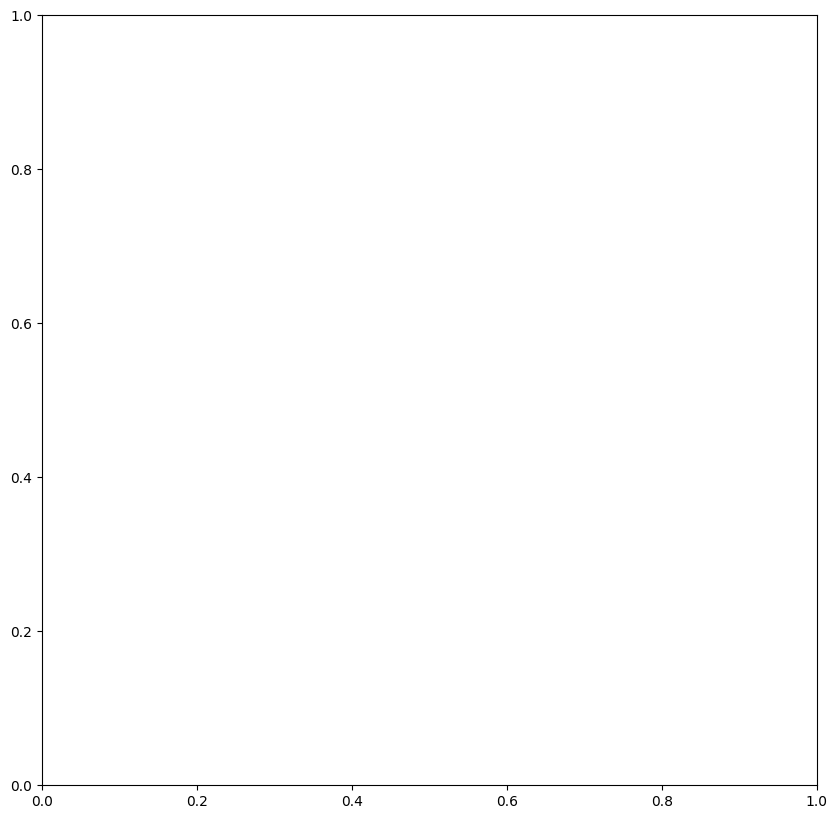

In [5]:
fig1, ax1 = plt.subplots(figsize=[10,10])
img1 = ax1.imshow(cube[4,:,:]-cube[3,:,:], cmap='Greys_r', vmin=-1e-11, vmax=1e-11, origin='lower')
plt.colorbar(img1, ax=ax1, fraction=0.02, label='MSB')
ROI1_rect = patches.Rectangle((150, 400), 50, 50, linewidth=2, edgecolor='blue', facecolor='none',
                              label='ROI1')
ax1.add_patch(ROI1_rect)
ROI2_rect = patches.Rectangle((150, 50), 50, 50, linewidth=2, edgecolor='orange', facecolor='none',
                              label='ROI2')
ax1.add_patch(ROI2_rect)
ax1.legend()

Or, alternatively, plotting animation of running difference

In [ ]:
fig_rd, ax_rd = plt.subplots(figsize=(8,6))

img_rd = ax_rd.imshow(cube[1,:,:]-cube[0,:,:], cmap='Greys_r', vmin=-1e-11, vmax=1e-11, origin='lower', interpolation='none')
cbar_rd = plt.colorbar(img_rd, ax=ax_rd, label='MSB')

t_arr = deltaT * np.arange(cube.shape[0])
ax_rd.set_title('$t={ti_min}$ min'.format(ti_min=t_arr[1]/60.0))

def animate_rd(i):
    img_rd.set_array(cube[1+i,:,:]-cube[0+i,:,:])
    ax_rd.set_title('$t={ti_min}$ min'.format(ti_min=t_arr[1+i]/60.0))
    return [img_rd]

ani_rd = animation.FuncAnimation(fig_rd, animate_rd, interval=100, blit=True, save_count=35)
plt.close(fig_rd)
ani_rd

## Power spectral density

In the following cell we estimate the power spectral density of the fluctuations along the temporal axis (axis=0 in our data cube). For this purpose we use the "periodogram" function contained in the scipy module and employ a Hamming window to limit the truncation effects due to the limit length of the data series

In [ ]:
nu, P = sig.periodogram(cube, 1./deltaT, nfft=128, detrend='linear', 
                        axis=0, window='hamming', return_onesided=True, 
                        scaling='density')

We select a RoI in the FoV and plot the average spectral density in the region

In [ ]:
avg_PSD_ROI1=np.mean(np.mean(P[:, 150:200, 400:450], axis=1), axis=1)
avg_PSD_ROI2=np.mean(np.mean(P[:, 150:200, 50:100], axis=1), axis=1)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=[10,7])
plt.plot(nu*1000., avg_PSD_ROI1, label='ROI 1')
plt.plot(nu*1000., avg_PSD_ROI2, label='ROI 2')
plt.legend()
plt.xlabel('Frequency (mHz)')
plt.ylabel('PSD $(s^{-2} Hz^{-1})$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1e-20, 2e-19)
#plt.xlim(0,nu.max()*1000.)

We plot the ratio of the spectra in the two selected regions to reveal possible differences in the power. This is done after normalizing the two spectra

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 19}
plt.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"

Norm_P_ROI1=avg_PSD_ROI1/np.sum(avg_PSD_ROI1)
Norm_P_ROI2=avg_PSD_ROI2/np.sum(avg_PSD_ROI2)

plt.figure(figsize=[10,7])
plt.plot(nu*1000., Norm_P_ROI1/Norm_P_ROI2)
plt.xlabel('Frequency (mHz)')
plt.ylabel('ROI1/ROI2 Power ratio')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,nu.max()*1000.)

## k-Omega filtering

We construct an apodization cube to limit the effects of edges of the occulter and the FoV in the Fourier space before applying a k-Omega filtering to the spatial coherence of the oscillations.

In [ ]:
#def dist(NAXIS):
#    axis = np.linspace(-NAXIS/2+1, NAXIS/2, NAXIS)
#    result = np.sqrt(axis**2 + axis[:,np.newaxis]**2)
#    return np.roll(result, int(NAXIS/2+1), axis=(0,1))

def dist2(NAXIS):
    axis = np.linspace(-NAXIS/2+1, NAXIS/2, NAXIS)
    result = np.sqrt(axis**2 + axis[:,np.newaxis]**2)
    return result

In [ ]:
#window2d = np.roll(np.roll(dist(512),[256], axis=0), 256, axis=1)
window2d = dist2(512)
inner_mask=np.roll(window2d > 150, -20, axis=0)
outer_mask=(window2d < 280)
mask=ndimage.gaussian_filter(np.float32(inner_mask*outer_mask), 3, mode='reflect')

This is how `mask` looks like

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(mask, origin='lower')
plt.colorbar(fraction=0.02,  pad=0.1)

Creating apodization cube

In [ ]:
cube_apod=cube.copy()

for i in range(36):
    cube_apod[i,:,:]=ndimage.gaussian_filter(mask*cube[i,:,:], 2, mode='reflect')    

Example of masked and smoothed cube layer

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(cube_apod[10,:,:], origin='lower', vmin=-3e-11, vmax=3e-11)
plt.colorbar(fraction=0.02,  pad=0.1)

Necessary functions for the k-Omega filtering. For more information about the k-Omega filtering see Jess et al. 2017 ApJ 842, 59

In [ ]:
def FFT_kO_filter_cube(cube, v0, sigma, k1, k2, sampling, profile=None):
    siz=np.shape(cube)
    filt=np.zeros([siz[0], siz[1], siz[2]])
    freq=frequency_vector(sampling, siz[0])
    gf=gaussian_filter(freq*1000., v0, sigma)
        
    if profile is not None:
        gf=profile
        print('Using custom profile')
    
    for i in range(siz[1]):
        for j in range(siz[2]):
            filt[:,i,j]=gf
    
    NAXIS=siz[1]
    axis = np.linspace(-NAXIS/2+1, NAXIS/2, NAXIS)
    di=np.roll(np.sqrt(axis**2 + axis[:,np.newaxis]**2), int(NAXIS/2+1), axis=(0,1))
    kf=np.zeros([siz[0], siz[1], siz[2]])
    wh=np.where((di > k1) & (di < k2))
    di2=di*0.
    di2[wh]=1
    di2=smooth(di2, [1.6,1.6], order=0, mode='reflect', cval=0.0, truncate=4.0)
    di2=di2/di2.max()
    
    for t in range(siz[0]):
        kf[t,:,:]=di2
    
    filt=filt*kf
    
    A=np.real(np.fft.ifftn(np.fft.fftn(cube)*filt))*2
    return A

def gaussian_filter(freq, v0, sigma):
    g=0
    for i in v0:
        g=g+(1./sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((freq-i)/sigma)**2.)
    
    g=g/g.max()
    return g

def frequency_vector(sampling, samples):
    s=np.arange(samples)
    freq=s/(sampling*samples)
    return freq

Specifying frequency band and the range of pixel sizes for k-Omega filtering

In [ ]:
v0=0.5  #central frequency in mHz of the bandpass <=>  30 min
bandpass=0.1  #mHz
k1 = 2  # pixels
k2 = 200  # pixels

Performing k-Omega filtering, we examine the temporal-spatial coherent oscilations of the structures at ~0.5 mHz (30 min) time scale and 2-200 pixels spatial scale.

In [ ]:
cube_filt=FFT_kO_filter_cube(cube_apod, [v0], bandpass, k1, k2, deltaT)

Plotting intensity fluctuations

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=[10,10])
plt.imshow(cube_filt[10,:,:], 
           cmap='bwr', vmin=-0.3*1e-11, vmax=0.3*1e-11, origin='lower',
           extent=[-256*40.5,256*40.5, -256*40.5, 256*40.5]
          )
plt.colorbar(fraction=0.02, label='MSB amplitude '+'$(s^{-2} Hz^{-1})$',  pad=0.1)
plt.ylabel('y-axis (arcsec)')
plt.xlabel('x-axis (arcsec)')

Or, alternatively, plotting animation of the filtered image (_left panel_) and running difference (_right panel_)  sequences

In [ ]:
fig_filt, (ax_filt, ax_rd) = plt.subplots(1, 2, figsize=(16,6))

img_filt = ax_filt.imshow(cube_filt[1,:,:], cmap='bwr', vmin=-0.3*1e-11, vmax=0.3*1e-11, origin='lower', interpolation='none')
cbar_filt = plt.colorbar(img_filt, ax=ax_filt, label='MSB amplitude '+'$(s^{-2}~Hz^{-1})$')

img_rd = ax_rd.imshow(cube[1,:,:]-cube[0,:,:], cmap='Greys_r', vmin=-1e-11, vmax=1e-11, origin='lower', interpolation='none')
cbar_rd = plt.colorbar(img_rd, ax=ax_rd, label='MSB')

t_arr = deltaT * np.arange(cube.shape[0])
fig_filt.suptitle('$t={ti_min}$ min'.format(ti_min=t_arr[1]/60.0))

def animate_filt(i):
    img_filt.set_array(cube_filt[1+i,:,:])
    img_rd.set_array(cube[1+i,:,:]-cube[0+i,:,:])
    fig_filt.suptitle('$t={ti_min}$ min'.format(ti_min=t_arr[1+i]/60.0))
    return [img_filt, img_rd]

ani_filt = animation.FuncAnimation(fig_filt, animate_filt, interval=200, blit=True, save_count=35)
plt.close(fig_filt)
ani_filt

We would like to **warn** users that the intensity fluctuations shown in previous figures should be considered with attention, since spurious structures can appear during k-Omega filtering (see e.g. the structure at the position of the bright field star at bottom right).